<a href="https://colab.research.google.com/github/beniciowg/data-science-projects/blob/master/Previs%C3%A3o_de_Churn_com_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Churn Prediction

<img src="https://docs.google.com/uc?export=download&id=1vE_md2mXC8vN3bQUyeH7d__xyF2S51tr" width="100%" align="center">

*Churn* é definido como a quantidade de clientes que cancelam o serviço da empresa em um determinado período de tempo. A taxa de *churn* (*churn rate*) mostra qual a porcentagem de cancelamento em relação ao total de clientes.

Para que seja possível para uma empresa aumentar a sua base de clientes e aumentar seu faturamento, é importante que o *churn* seja menor do que o número de clientes novos. É um índice extremamente importante e que pode ser essencial na análise da aceitação dos produtos e serviços de uma empresa no mercado.

Em geral, os custos para manter um cliente são menores do que o Custo de Aquisição de Cliente (CAC). Por isso, é muito importante conseguir prever quando ocorrerá um *churn* para que possam ser tomadas medidas para que o cliente permaneça.

Neste notebook, vamos utilizar os dados de clientes de uma empresa de telecomunicações para analisar os perfis dos clientes que realizaram *churn* e criar um modelo de classificação para prever um potencial cancelamento.


## Aquisição dos Dados

Para este projeto, os dados foram adquiridos da [plataforma de ensino da IBM Developer](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#) e são referentes a uma empresa do setor de Telecomunicações. Não foram disponibilizadas muitas informações sobre as colunas, mas explorando-as conseguimos entendê-las melhor.


In [1]:
#@title
!pip install scikit-optimize -q

In [2]:
#@title
!pip install scikit-plot -q

In [3]:
# importando os pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.model_selection import StratifiedKFold
import scikitplot as skplt
from sklearn.metrics import auc, classification_report, confusion_matrix, precision_recall_curve, recall_score

sns.set_style('dark')

# importar os dados
DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

# ver as 5 primeiras entradas
df.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Vemos a presença de uma coluna com o ID do cliente e três colunas numéricas (`tenure`, `MonthlyCharges` e `TotalCharges`). Além disso, nosso dataset possui muitas variáveis categóricas e, com exceção de `SeniorCitizen`, todas possuem categorias designadas por texto. Isso deverá ser tratado mais a frente para que possamos utilizá-las em nossos modelos de *machine learning*.

`MonthlyCharges` e `TotalCharges` são intuitivas de se entender, sendo referentes às cobranças mensais feitas a um cliente e o total que pagou ao longo do tempo até agora, respectivamente. `tenure`, no entanto, requer um pouco de pesquisa e significa o tempo (em meses) que o cliente está na empresa ou o tempo que ele permaneceu até sair.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Verificamos que nosso dataset possui 7043 entradas e 21 colunas. Pode-se destacar também o fato de não termos valores nulos. Entretanto, a coluna `TotalCharges`está como tipo `object` enquanto deveria ser do tipo `float`.

Ao tentar rodar o seguinte código: `df['TotalCharges'].astype(float)`, obtemos um erro. Isso significa que algum valor de nossa coluna não é numérico, podendo ser algum texto colocado de forma errada ou valores não preenchidos. Vamos primeiramente procurar por valores não preenchidos.

In [5]:
# procurando por valores não preenchidos
df[df['TotalCharges'] == " "]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [6]:
print(f'Quantidade de valores não preenchidos: {df[df.TotalCharges == " "].shape[0]}')

Quantidade de valores não preenchidos: 11


Podemos perceber que temos 11 entradas na coluna `TotalCharges` que não foram preenchidas corretamente e, por isso, vamos criar uma função para transformá-la para o tipo `float` e retornar como `NaN` os valores não preenchidos. Após a conversão, iremos tratar tais valores substituindo-os pela mediana.

In [7]:
def conversor_str_float(arg):
  """
Converte uma entrada do tipo string em float

# Argumento: str
# Retorna: valor ou lista convertido para o tipo float
# Em caso de erro retorna NaN

  """
  try:
    return float(arg)
  except ValueError:
    return np.nan

# criando uma cópia do dataset para realizar as operações de limpeza
df_clean = df.copy()

# usando o conversor criado para converter nossa coluna TotalCharges em float
df_clean['TotalCharges'] = df_clean['TotalCharges'].apply(conversor_str_float)

# verificando o tipo e a quantidade de valores nulos em TotalCharges
print(f'Tipo de TotalCharges: {df_clean.TotalCharges.dtype}')
print(f'Quantidade de valores nulos: {df_clean["TotalCharges"].isnull().sum()}')

Tipo de TotalCharges: float64
Quantidade de valores nulos: 11


In [8]:
# preencher os valores nulos de TotalCharges com a mediana
median = df_clean['TotalCharges'].median()
df_clean['TotalCharges'].fillna(median, inplace=True)

# checando o número de valores nulos para ter certeza que foram preenchidos
print(f'Quantidade de valores nulos: {df_clean["TotalCharges"].isnull().sum()}')

Quantidade de valores nulos: 0


Pronto! Conferimos que a coluna `TotalCharges` está com o tipo correto e os valores nulos batem com a quantidade de entradas sem preenchimento, o que significa que não temos mais entradas preenchidas de forma equivocada. Após preenchermos com a mediana, a coluna não possui mais valores ausentes.

Vamos prosseguir com a análise conferindo o número de valores únicos por coluna, poderemos verificar quais colunas categóricas são binárias e quais possuem mais de duas categorias, assim como se há algum cliente com mais de uma entrada.

In [9]:
# verificando o quantidade de valores únicos em cada coluna
print('Quantidade de valores únicos por coluna:', '\n')

for col in df_clean.columns:
  print(f'{col}: {df_clean[col].nunique()}')

Quantidade de valores únicos por coluna: 

customerID: 7043
gender: 2
SeniorCitizen: 2
Partner: 2
Dependents: 2
tenure: 73
PhoneService: 2
MultipleLines: 3
InternetService: 3
OnlineSecurity: 3
OnlineBackup: 3
DeviceProtection: 3
TechSupport: 3
StreamingTV: 3
StreamingMovies: 3
Contract: 3
PaperlessBilling: 2
PaymentMethod: 4
MonthlyCharges: 1585
TotalCharges: 6531
Churn: 2


A coluna de `costumerID` possui 7043 entradas diferentes, o que denota que não há informações duplicadas de clientes.

Pode-se perceber, também, que temos 7 colunas categóricas binárias, 9 contendo 3 categorias diferentes e apenas uma com 4 categorias. Nosso dataset apresenta informações redundantes, pois possuimos uma coluna que indica se o cliente possui serviço de internet (`InternetService`) e outra se possui serviço telefônico (`PhoneService`) e também temos essas informações dentro de outras colunas categóricas (`MultipleLines`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV` e `StreamingMovies`). 

Sendo assim, iremos substituir as entradas de *No phone service* e *No internet service* por *No*.

In [10]:
# substituindo o preenchimento
replace = {'No phone service': 'No',
           'No internet service': 'No'}
df_clean.replace(replace, inplace=True)

# verificando o quantidade de valores únicos em cada coluna
print('Quantidade de valores únicos por coluna:', '\n')

for col in df_clean.columns:
  print(f'{col}: {df_clean[col].nunique()}')

Quantidade de valores únicos por coluna: 

customerID: 7043
gender: 2
SeniorCitizen: 2
Partner: 2
Dependents: 2
tenure: 73
PhoneService: 2
MultipleLines: 2
InternetService: 3
OnlineSecurity: 2
OnlineBackup: 2
DeviceProtection: 2
TechSupport: 2
StreamingTV: 2
StreamingMovies: 2
Contract: 3
PaperlessBilling: 2
PaymentMethod: 4
MonthlyCharges: 1585
TotalCharges: 6531
Churn: 2


Agora, as únicas colunas categóricas não-binárias são `InternetService`, `Contract` e `PaymentMethod`.

Para facilitar a visualização quando construirmos nossos gráficos para verificar as distribuições de cada variável, iremos trocar as entradas da variável `SeniorCitizen` de 0 e 1 para *No* e *Yes*. Ademais, vamos fazer o processo inverso com a coluna `Churn`, tornando possível calcular a taxa de *churn* para as diferentes categorias das outras variáveis. Por último, vamos retirar o *(automatic)* das entradas da coluna `PaymentMethod` e deletar a coluna `CostumerID` que não nos terá mais serventia daqui por diante.

In [11]:
# alterando as entradas da coluna `SeniorCitizen`
sc_replace = {0: 'No', 1: 'Yes'}
df_clean['SeniorCitizen'].replace(sc_replace, inplace=True)

df_clean['SeniorCitizen'].unique()

array(['No', 'Yes'], dtype=object)

In [12]:
# alterando as entradas da coluna Churn
churn_replace = {'No': 0, 'Yes': 1}
df_clean['Churn'].replace(churn_replace, inplace=True)

df_clean['Churn'].unique()

array([0, 1])

In [13]:
# excluindo a coluna costumerID
df_clean.drop('customerID', axis=1, inplace=True)

# alterando as entradas da coluna PaymentMethod
df_clean['PaymentMethod'].replace('Bank transfer (automatic)', 'Bank transfer', inplace=True)
df_clean['PaymentMethod'].replace('Credit card (automatic)', 'Credit Card', inplace=True)

df_clean['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer', 'Credit Card'],
      dtype=object)

Agora que ajustamos os valores de nossas entradas, podemos verificar qual foi a taxa de churn da empresa de nosso dataset.

In [14]:
# verificando a taxa de churn no dataset
churn_yes = df_clean[df_clean['Churn'] == 1].shape[0]

print(f'Taxa de Churn: {round(churn_yes / df_clean.shape[0], 2)}')

Taxa de Churn: 0.27


De todos os clientes, 27% encerraram seus contratos após começar a utilizar os serviços da empresa.

Utilizando o método `describe()`, construiremos um resumo estatístico de nossas variáveis numéricas.

In [15]:
df_clean.drop('Churn', axis=1).describe().round(2)

,tenure,MonthlyCharges,TotalCharges
count,7043.00,7043.00,7043.00
mean,32.37,64.76,2281.92
std,24.56,30.09,2265.27
min,0.00,18.25,18.80
25%,9.00,35.50,402.22
50%,29.00,70.35,1397.48
75%,55.00,89.85,3786.60
max,72.00,118.75,8684.80


Através do resumo estatístico acima, percebe-se que nenhuma de nossas variáveis numéricas apresenta valores muito discrepantes de minímo e máximo, não indicando presença de possíveis *outliers*. Para ter certeza, vamos construir *boxplots* para as mesmas.

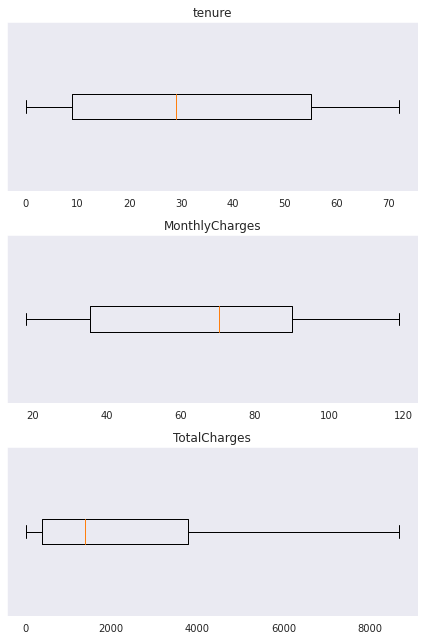

In [40]:
# criando a figura e os axes para nossos boxplots
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(6, 9))

# boxplot da coluna tenure
ax1.boxplot(df_clean['tenure'], vert=False)
ax1.set_title('tenure')
ax1.set_yticklabels([])

# boxplot da coluna MonthlyCharges
ax2.boxplot(df_clean['MonthlyCharges'], vert=False)
ax2.set_title('MonthlyCharges')
ax2.set_yticklabels([])

# boxplot da coluna TotalCharges
ax3.boxplot(df_clean['TotalCharges'], vert=False)
ax3.set_title('TotalCharges')
ax3.set_yticklabels([])

plt.tight_layout()

Podemos confirmar então que não há outliers em nossas variáveis numéricas, visto que não há pontos fora dos quartis em todas elas.

Agora, vamos analisar a distribuição das classes de nossas variáveis categóricas, com exceção de `Churn` que será analisada mais a frente.

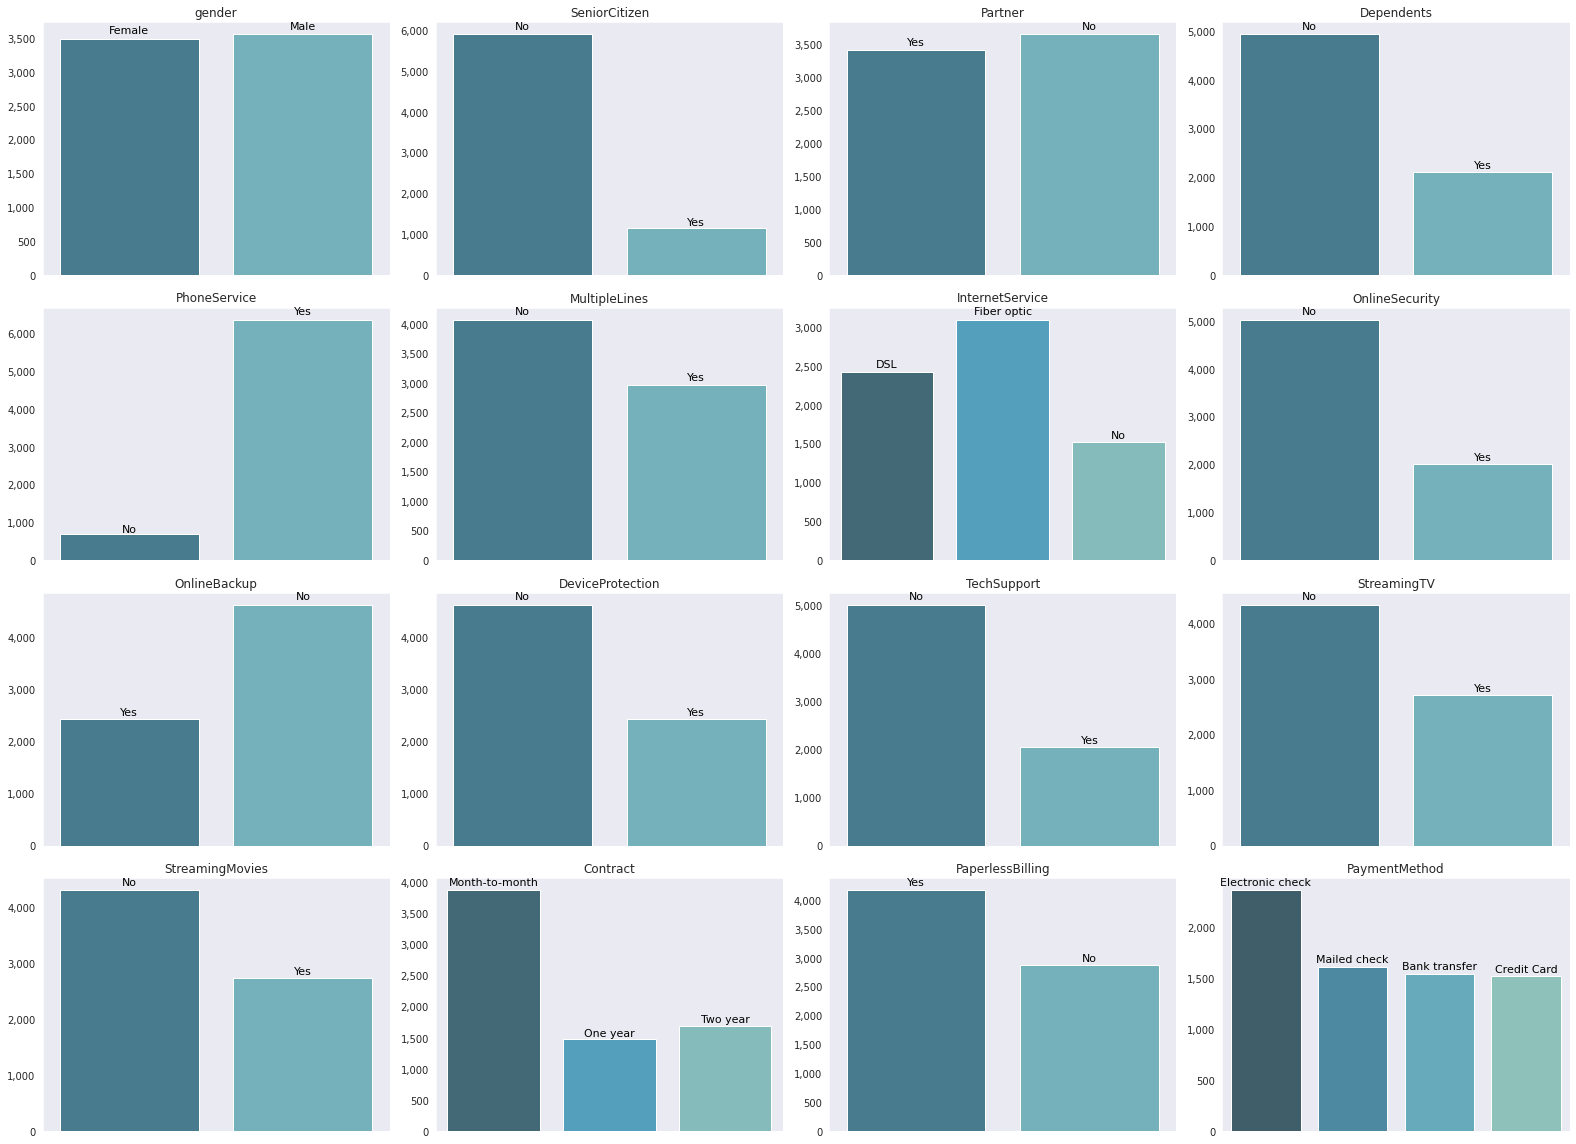

In [16]:
# criando uma lista com as colunas categóricas binárias
categorical = []

for col in df_clean.columns:
  if df_clean[col].nunique() < 5 and col != 'Churn':
    categorical.append(col)

# criando um gráfico com suas distribuições
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(22,16))
i = 0

for col in categorical:
  i += 1
  plt.subplot(4, 4, i)
  g = sns.countplot(df_clean[col], palette='GnBu_d')
  plt.xlabel('')
  plt.xticks([])
  plt.ylabel('')
  plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
  plt.title(col)

  for p, q in zip(g.patches, df_clean[col].unique()):
        g.annotate(f'{q}', (p.get_x()+0.4, 1.015*p.get_height()), ha='center',
                   va='bottom', color='black', fontsize=11)  

plt.tight_layout()

É relativamente comum termos desbalanceamentos relacionados ao sexo que podem causar vieses em modelos preditivos. No entanto, não é o caso de nosso dataset, onde a coluna `gender` está balanceada. Outras colunas como `PhoneService` e `SeniorCitizen`, por outro lado, apresentam um alto desbalanceamento.

É importante verificarmos como nossas variáveis se relacionam com a nossa variável alvo, pois as que apresentarem taxas de *churn* muito próximas para diferentes categorias não serão relevantes para nossos modelos e os tornarão mais pesados.

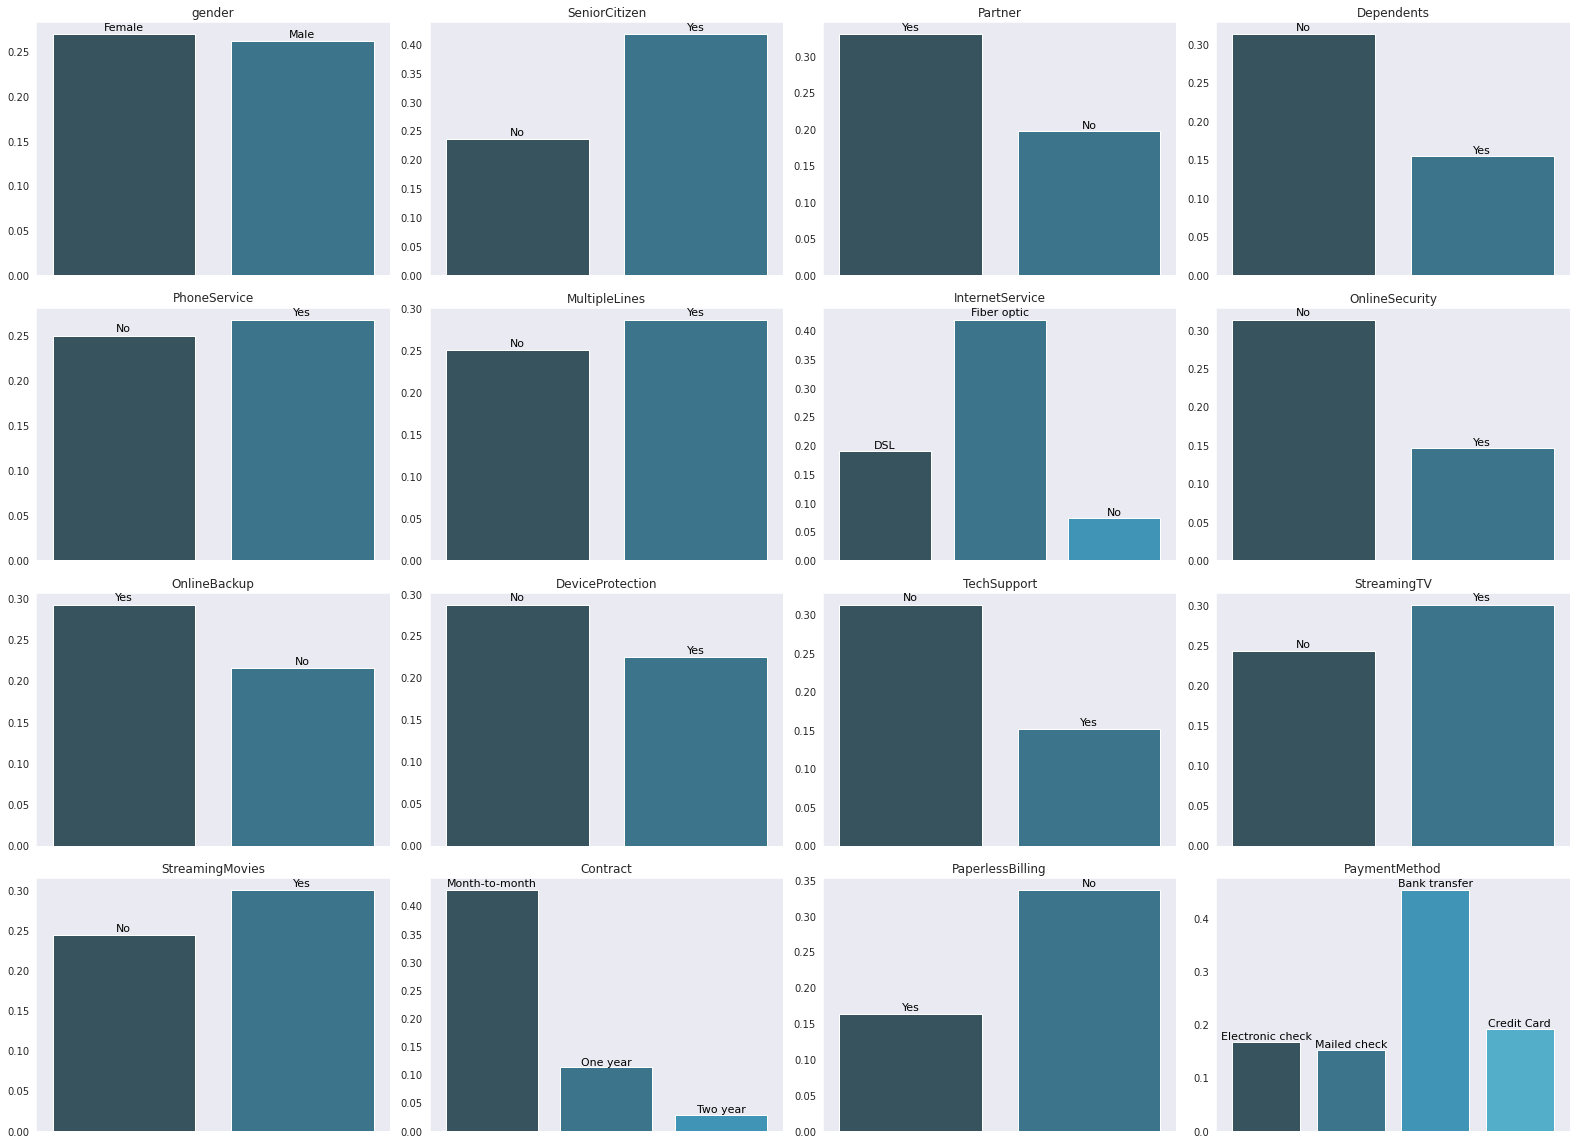

In [17]:
# criando um gráfico com suas distribuições
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(22,16))
i = 0

for col in categorical:
  i += 1
  plt.subplot(4, 4, i)
  ax1 = plt.gca()
  plot = df_clean[[col, 'Churn']].groupby([col], as_index=False).mean()
  g = ax1.bar(col, 'Churn', data=plot, color=sns.color_palette('GnBu_d'))
  plt.xlabel('')
  plt.xticks([])
  plt.title(col)
    
  for p, q in zip(g.patches, df_clean[col].unique()):
      ax1.annotate(f'{q}', (p.get_x()+0.4, 1.010*p.get_height()), ha='center',
                   va='bottom', color='black', fontsize=11)   

plt.tight_layout()

Podemos tirar algumas informações valiosas do gráfico acima:
* Clientes casados e sem dependentes tem uma tendência maior a realizar *churn*;

* Clientes que não aderem a outros serviços como suporte técnico, backup e segurança online e proteção de dispositivos, também apresentam maior tendência a sair da empresa. Visto que esses clientes são minoria em relação aos que não assinam, talvez seja interessante investir em campanhas que aumentem a taxa de adesão a eles;

* Apesar de não apresentar uma diferença tão grande, os clientes que assinam serviços de *streaming* tanto de filme quanto de TV apresentam uma maior taxa de *churn*, isso pode indicar que esses serviços podem estar causando incômodos aos clientes e devem ser melhorados;

* Outro ponto de atenção é que a maior parte dos clientes realizam pagamentos sem uso de contas em papel e os mesmos também apresentam maior propensão a cancelar os serviços da empresa. Isso se dá pela maior facilidade de quem usa mais frequentemente meios eletrônicos em cancelar os serviços de forma online? Ou será que há problemas no envio e confirmação de pagamentos feitos de maneira eletrônica?

* Podendo estar relacionado ao tópico anterior, clientes que realizam transferência bancária possuem muito mais tendência a deixar a companhia do que clientes que usam outros meios de pagamento;

* Como esperado, quanto maior o tempo de contrato, menor a taxa de *churn*. Campanhas que estimulem adesão a contratos de longo prazo podem ajudar a diminuir a taxa de *churn*;

* Clientes que possuem internet da companhia com fibra ótica deixam a empresa numa taxa muito maior do que os que não têm internet ou que a internet é com DSL. Possivelmente a qualidade do serviço de internet com a fibra ótica está deixando a desejar e está fazendo os clientes migrarem para concorrentes. Isso é prepocupante, pois a maioria dos clientes possui fibra ótica e também pode estar ligado à qualidade do *streaming*;

* A variável relacionada a sexo não nos dá nenhuma informação a respeito da taxa de churn e pode ser excluída de nosso dataset.

Vamos verificar o preço médio para as diferentes categorias da coluna de `InternetService`.


In [18]:
# verificando o preço médio por tipo de serviço de internet
df_clean[['InternetService', 'MonthlyCharges']].groupby('InternetService').mean().round(2)

,MonthlyCharges
InternetService,
DSL,58.10
Fiber optic,91.50
No,21.08


Os clientes que assinam internet com fibra ótica pagam bem mais caro do que os que utilizam DSL. Esse também pode ser um motivo para a maior taxa de *churn* para clientes com fibra ótica, talvez até o principal deles. Planos promocionais para essa categoria podem ser interessantes para maior retenção de clientes.

In [19]:
# verificando tempo médio de permanência e cobranças mensais
df_clean[['Churn', 'tenure', 'MonthlyCharges']].groupby('Churn').mean().round(2)

,tenure,MonthlyCharges
Churn,,
0,37.57,61.27
1,17.98,74.44


Podemos ver que o tempo médio de permanência na empresa dos clientes que cancelaram seus serviços é de aproximadamente 18 meses. Além disso, outro dado interessante é que os clientes que realizaram *churn* são os que pagavam por serviços mais caros. Provavelmente para esses clientes, o custo benefício dos serviços da empresa não eram adequados, algo que poderia ser interessante de ser investigado mais a fundo.

## Preparação dos Dados

Antes de iniciarmos a criação de nossos modelos para comparação, é de extrema importância deletarmos as colunas desnecessárias como `gender` e `MultipleLines` e realizar *Encoding* com as colunas categóricas.

O *Label Encoder* atribui um valor numérico para cada categoria da coluna especificada. Já a função `get_dummies` do Pandas cria uma coluna para cada categoria da coluna especificada e atribui o valor 1 para as entradas correspondentes àquela categoria e 0 para as outras.

Em geral, em colunas binárias utilizamos o *Label Encoder*. Porém, para colunas com múltiplas categorias, esse método pode passar uma hierarquia inexistente para os modelos de *machine learning*. Por exemplo, em uma coluna com 6 categorias diferentes podem ser atribuídos valores de 0 a 5 e o modelo dar maior importância à categoria 5 por ser um número maior. Para evitar erros desse tipo, utilizaremos o `get_dummies` para as colunas com mais de 2 categorias.

In [20]:
# criando uma cópia e deletando as colunas gender e MultipleLines
df_proc = df_clean.copy()
df_proc.drop(['gender', 'MultipleLines'], axis=1, inplace=True)

# separando as colunas por binárias, numéricas e categóricas
binary = [col for col in df_proc.columns if df_proc[col].nunique() == 2]
numerical = [col for col in df_proc.select_dtypes(['int', 'float']).columns if col not in binary]
categorical = [col for col in df_proc.columns if col not in binary + numerical]

# LabelEncoder para as colunas binárias
le = LabelEncoder()

for col in binary:
  df_proc[col] = le.fit_transform(df_proc[col])

# get_dummies para as outras colunas categóricas
df_proc = pd.get_dummies(df_proc, columns=categorical)

df_proc.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer,PaymentMethod_Credit Card,PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,0,1,0,0,1,0,0,0,0,1,29.85,29.85,0,1,0,0,1,0,0,0,0,1,0
1,0,0,0,34,1,1,0,1,0,0,0,0,56.95,1889.50,0,1,0,0,0,1,0,0,0,0,1
2,0,0,0,2,1,1,1,0,0,0,0,1,53.85,108.15,1,1,0,0,1,0,0,0,0,0,1
3,0,0,0,45,0,1,0,1,1,0,0,0,42.30,1840.75,0,1,0,0,0,1,0,1,0,0,0
4,0,0,0,2,1,0,0,0,0,0,0,1,70.70,151.65,1,0,1,0,1,0,0,0,0,1,0


Pronto! Agora que nossas variáveis já foram preparadas, vamos dividir nosso *dataset* em treino e teste.

In [21]:
# separando a variável alvo das demais
X = df_proc.drop('Churn', axis=1)
y = df_proc['Churn']

# dividindo o dataset entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y)

Vamos verificar agora se nossa variável alvo está balanceada ou se será necessário utilizar técnicas para balanceamento das categorias da mesma.

0    5174
1    1869
Name: Churn, dtype: int64


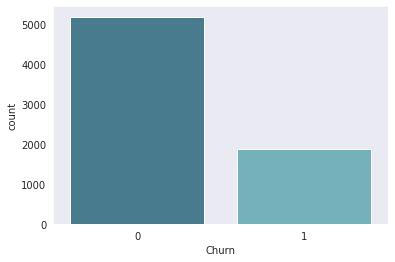

In [46]:
print(df_proc['Churn'].value_counts())

sns.countplot(df_proc['Churn'], palette='GnBu_d')

plt.show()

Podemos verificar que nossas classes estão desbalanceadas, sendo assim, mais a frente iremos utilizar técnicas para lidar com este problema e não gerar viés em nossos modelos.

## Construção dos Modelos

O primeiro passo para criação e avaliação de nossos modelos é definir quais as métricas de avaliação mais importantes. Para saber mais sobre as métricas de avaliação de modelos de classificação, [acesse este meu artigo no Medium](https://medium.com/@beniciowg/detec%C3%A7%C3%A3o-de-fraudes-em-cart%C3%B5es-de-cr%C3%A9dito-a-import%C3%A2ncia-das-m%C3%A9tricas-de-avalia%C3%A7%C3%A3o-71ed59f35293). 

Neste caso em específico estamos interessados em prever se um cliente deixará a empresa ou não. Caso um cliente que não deixaria a empresa for classificado como um *churn* em potencial quais seriam os prejuízos? A empresa somente buscaria estudar mais a fundo as atividades desse cliente? Apresentaria promoções ou daria bônus? 

Enfim, para este projeto assumiremos que a métrica principal para avaliação dos modelos é *Recall*, pois queremos detectar a maior quantidade de clientes possíveis com potencial de deixar a empresa.

Começaremos criando uma função que padroniza nossos dados e retorna o valor obtido para *Recall* após utilizar *cross-validation*.

In [23]:
# criando uma função para avaliar nossos modelos com cross-validation
def val_model(clf, X, y, print_val=True):
  """
  Cria um pipeline com a aplicação de um padronizador e do classificador e avalia com cross-validation

  # Argumentos:
    clf: classificador
    X: conjunto de variáveis independentes para treino
    y: variável dependente para treino
    print_val: bool, se True imprime o valor obtido
  
  # Retorna: 
    float: média dos scores obtidos no cross-validation
  """

  pipeline = make_pipeline(StandardScaler(), clf)
  score = cross_val_score(pipeline, X, y, scoring='recall')

  if print_val == True:
    print(f'Recall: {round(score.mean(), 2)} +/- {round(score.std(), 2)}')

  return score.mean()

### Criando um Modelo de Referência

Vamos criar um modelo de referência utilizando o XGBoost, que é considerado estado da arte em muitas aplicações. Este modelo será aplicado em nosso *dataset* sem realizar padronização dos dados, utilizar técnicas de *sampling* ou otimizar parâmetros. Ele será utilizado como uma referência a ser batida pelos outros modelos.

In [24]:
xgb = XGBClassifier()
score_baseline = val_model(xgb, X_train, y_train)

Recall: 0.52 +/- 0.04


O valor de *Recall* obtido pelo nosso modelo de referência foi de 0.52, ou seja, com ele 52% dos clientes que realizariam *churn* seriam detectados previamente.

### Padronização e Balanceamento dos Dados

O próximo passo é realizar a padronização dos nossos dados de treino, ou seja, deixá-los todos na mesma escala para que não haja nenhum viés em nosso modelo causado por diferenças na escala dos valores de diferentes variáveis. Após a padronização dos dados, iremos aplicar duas técnicas de balanceamento das categorias da variável alvo: *Undersampling* e *SMOTE*.

A técnica de *Undersampling* consiste em pegar todas as entradas do conjunto de treino da categoria positiva (clientes que realizaram *churn*) e selecionar aleatoriamente a mesma quantidade de entradas para a classe negativa (clientes que continuam na empresa). A vantagem dessa técnica é que não há alterações na classe positiva e a desvantagem é que se perde muita informação da classe negativa.

Já a técnica de *SMOTE* cria novas instâncias da classe minoritária selecionando aleatoriamente uma entrada dessa classe e traçando uma linha até seus *k* vizinhos mais próximos (*k* geralmente é 5). Após encontrar os vizinhos mais próximos, seleciona-se aleatoriamente um deles e cria-se uma nova instância ao longo da linha traçada entre os dois pontos. A vantagem dessa técnica é que não se perde informações da classe majoritária e os exemplos criados são próximos aos já existentes. No entanto, se as ambas as classes forem próximas ele pode criar exemplos ambíguos, ou seja, sobrepor pontos criados para a classe minoritária com pontos da majoritária.

In [25]:
# padronizando os dados
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


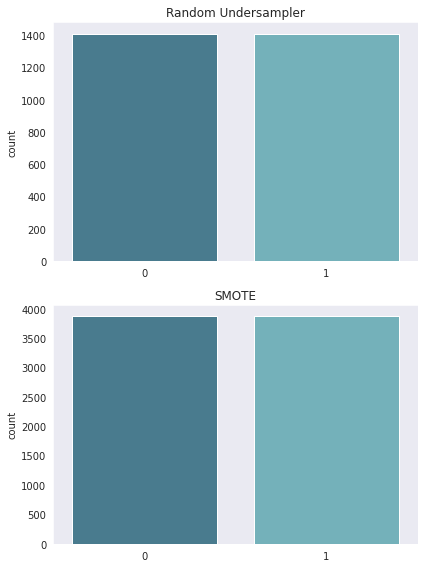

In [45]:
# instanciando o Random UnderSampler e ajustando aos nossos dados de treino
rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)

# instanciando o SMOTE e ajustando aos nossos dados de treino
oversample = SMOTE()
X_train_over, y_train_over = oversample.fit_sample(X_train, y_train)

# criando a figura com os countplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6,8))

sns.countplot(y_train_rus, ax=ax1, palette='GnBu_d')
ax1.set_title('Random Undersampler')

sns.countplot(y_train_over, ax=ax2, palette='GnBu_d')
ax2.set_title('SMOTE')

plt.tight_layout()

Podemos ver que ambas as técnicas balancearam os dados de treino, porém, elas diferem na quantidade de instâncias.

### Comparando Modelos

Para obter os melhores resultados possíveis, vamos avaliar o *Recall* para diferentes classificadores com ambas as técnicas de balanceamento. Os classificadores que iremos comparar são o XGBoost (*Extreme Gradient Boosting*), Regressão Logística, SVC (*Support Vector Classifier*), *Random Forest* e LGBM (*Light Gradient Boosting Machine*).

In [27]:
# instanciando os outros classificadores
lr = LogisticRegression()
svc = SVC()
rf = RandomForestClassifier()
lgbm = LGBMClassifier()

# criando listas de scores e classificadores
scores_rus = []
scores_over = []
models = []

# aplicando a função de avaliação que criamos e criando listas com os scores
for clf in [lr, svc, rf, lgbm, xgb]:
  models.append(clf.__class__.__name__)
  scores_rus.append(round(val_model(clf, X_train_rus, y_train_rus, print_val=False), 4))
  scores_over.append(round(val_model(clf, X_train_over, y_train_over, print_val=False), 4))

In [28]:
# criando uma tabela com os modelos e os scores obtidos
pd.DataFrame(data={'Recall RUS': scores_rus,
                   'Recall SMOTE:': scores_over}, 
             index=models)

,Recall RUS,Recall SMOTE:
LogisticRegression,0.7936,0.8210
SVC,0.8057,0.8419
RandomForestClassifier,0.7823,0.8638
LGBMClassifier,0.7844,0.8419
XGBClassifier,0.8064,0.8582


Pode-se perceber que os modelos obtiveram melhor performance com a técnica SMOTE. Além disso, os classificadores com melhores avaliações foram *Random Forest* e XGBoost, respectivamente. Sendo assim, iremos otimizar os hiperparâmetros para ambos os classificadores com otimização Bayesiana, falo mais sobre este algoritmo [neste artigo](https://medium.com/@beniciowg/como-tunar-hiperpar%C3%A2metros-com-otimiza%C3%A7%C3%A3o-bayesiana-5687fd51370f). Novamente, vamos comparar sua performance entre as diferentes técnicas de balanceamento dos dados.

In [29]:
# instanciando o classificador
xgb = XGBClassifier(random_state=1)

# determinando a faixa de valores a serem testados para cada hiperparâmetro
space = {
    'max_depth': Integer(1, 25),
    'learning_rate': Real(1e-3, 1e-1, 'log-uniform'),
    'gamma': Real(0.05, 1.0, 'log-uniform'),
    'min_child_weight': Integer(1, 50),
    'subsample': Real(0.05, 1.0),
    'colsample_bytree': Real(0.06, 1.0)
}

# definindo o número de divisões para o cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True)

# instanciando o otimizador e aplicando-o aos nossos dados
xgb_opt_rus = BayesSearchCV(xgb, space, n_iter=32, random_state=2, cv=cv, 
                    return_train_score=True, scoring='recall', refit=True)
xgb_opt_rus.fit(X_train_rus, y_train_rus)

print(f'Best Recall: {round(xgb_opt_rus.best_score_, 4)}')

Best Recall: 0.8844


O melhor *Recall* obtido dentro do cross-validation com o XGBoost e a técnica de Undersampling foi de 0.88. Agora, vamos padronizar os dados do conjunto de teste e aplicar o modelo para avaliarmos.

In [30]:
# instanciando o padronizador e aplicando ao conjunto de teste
scaler = StandardScaler().fit(X_test)
X_test = scaler.transform(X_test)

              precision    recall  f1-score   support

           0       0.94      0.58      0.71      1302
           1       0.42      0.89      0.57       459

    accuracy                           0.66      1761
   macro avg       0.68      0.73      0.64      1761
weighted avg       0.80      0.66      0.68      1761

AUC: 0.64


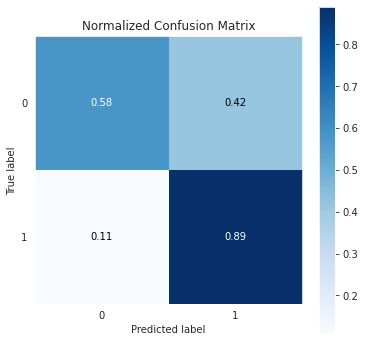

In [31]:
# realizando a classificação do conjunto de teste com nosso modelo otimizado
y_pred = xgb_opt_rus.predict(X_test)
y_prob = xgb_opt_rus.predict_proba(X_test)

precision, recall, threshold = precision_recall_curve(y_test, y_prob[:, 1])

print(classification_report(y_test, y_pred))
print(f'AUC: {round(auc(recall, precision), 2)}')
skplt.metrics.plot_confusion_matrix(y_test, y_pred, figsize=(6,6), normalize=True);

O valor obtido no conjunto de teste foi de 0.89, levemente superior ao obtido com o cross-validation, o que é bom, pois denota que nosso modelo não está com overfitting. O ponto negativo é que podemos perceber que o *Precision* está com um valor baixo (0.58), ou seja, 42% dos clientes que não realizaram *churn* foram classificados como sendo da classe positiva (clientes que realizaram *churn*).

In [32]:
# instanciando o classificador
xgb = XGBClassifier(random_state=3)

# determinando a faixa de valores a serem testados para cada hiperparâmetro
space = {
    'max_depth': Integer(1, 25),
    'learning_rate': Real(1e-3, 1e-1, 'log-uniform'),
    'gamma': Real(0.05, 1.0, 'log-uniform'),
    'min_child_weight': Integer(1, 50),
    'subsample': Real(0.05, 1.0),
    'colsample_bytree': Real(0.06, 1.0)
}

# definindo o número de divisões para o cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True)

# instanciando o otimizador e aplicando-o aos nossos dados
xgb_opt_over = BayesSearchCV(xgb, space, n_iter=32, random_state=4, cv=cv, 
                    return_train_score=True, scoring='recall', refit=True)
xgb_opt_over.fit(X_train_over, y_train_over)

print(f'Best Recall: {round(xgb_opt_over.best_score_, 4)}')

Best Recall: 1.0


Verificamos que o *Recall* para o XGBoost com SMOTE obteve valor máximo de 1.0. Isso pode parecer bom, mas é bem provável que tenha ocorrido um overfitting em nossos dados de treino e que esse modelo não performará tão bem nos dados de teste. Vamos conferir!

              precision    recall  f1-score   support

           0       0.86      0.65      0.74      1302
           1       0.41      0.71      0.52       459

    accuracy                           0.66      1761
   macro avg       0.64      0.68      0.63      1761
weighted avg       0.75      0.66      0.68      1761

AUC: 0.57


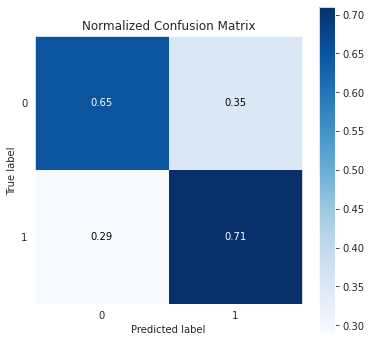

In [33]:
# realizando a classificação do conjunto de teste com nosso modelo otimizado
y_pred = xgb_opt_over.predict(X_test)
y_prob = xgb_opt_over.predict_proba(X_test)

precision, recall, threshold = precision_recall_curve(y_test, y_prob[:, 1])

print(classification_report(y_test, y_pred))
print(f'AUC: {round(auc(recall, precision), 2)}')
skplt.metrics.plot_confusion_matrix(y_test, y_pred, figsize=(6,6), normalize=True);

Como imaginamos, o *Recall* obtido no conjunto de teste foi de 0.71, bem abaixo dos modelos sem otimização. Isso se dá devido ao *overfitting* do modelo aos nossos dados de treino, não funcionando bem ao classificar dados fora desse conjunto. Vamos otimizar agora os hiperparâmetros para o *Random Forest*.

In [34]:
# instanciando o classificador
rf = RandomForestClassifier(random_state=5)

# determinando a faixa de valores a serem testados para cada hiperparâmetro
space = {
    'max_depth': Integer(1, 30),
    'n_estimators': Integer(10, 1000),
    'min_samples_split': Integer(2, 100),
    'min_samples_leaf': Integer(1, 10),
    'max_features': Integer(1, 20)
}

# definindo o número de divisões para o cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True)

# instanciando o otimizador e aplicando-o aos nossos dados
rf_opt_rus = BayesSearchCV(rf, space, n_iter=32, random_state=6, cv=cv, 
                    return_train_score=True, scoring='recall', refit=True)
rf_opt_rus.fit(X_train_rus, y_train_rus)

print(f'Best Recall: {round(rf_opt_rus.best_score_, 4)}')

Best Recall: 0.8844


              precision    recall  f1-score   support

           0       0.94      0.58      0.71      1302
           1       0.42      0.89      0.57       459

    accuracy                           0.66      1761
   macro avg       0.68      0.73      0.64      1761
weighted avg       0.80      0.66      0.68      1761

AUC: 0.63


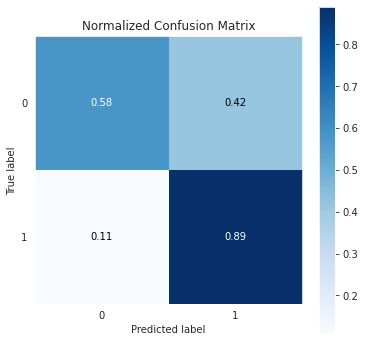

In [35]:
# realizando a classificação do conjunto de teste com nosso modelo otimizado
y_pred = rf_opt_rus.predict(X_test)
y_prob = rf_opt_rus.predict_proba(X_test)

precision, recall, threshold = precision_recall_curve(y_test, y_prob[:, 1])

print(classification_report(y_test, y_pred))
print(f'AUC: {round(auc(recall, precision), 2)}')
skplt.metrics.plot_confusion_matrix(y_test, y_pred, figsize=(6,6), normalize=True);

Nosso modelo de *Random Forest* obteve uma performance muito semelhante ao XGBoost com a técnica de *Undersampling*, com um *Recall* de 0.88 para o cross-validation e 0.89 nos dados de teste. Por último, vamos analisar o *Random Forest* com SMOTE.

In [36]:
# instanciando o classificador
rf = RandomForestClassifier(random_state=7)

# determinando a faixa de valores a serem testados para cada hiperparâmetro
space = {
    'max_depth': Integer(1, 30),
    'n_estimators': Integer(10, 1000),
    'min_samples_split': Integer(2, 100),
    'min_samples_leaf': Integer(1, 10),
    'max_features': Integer(1, 20)
}

# definindo o número de divisões para o cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True)

# instanciando o otimizador e aplicando-o aos nossos dados
rf_opt_over = BayesSearchCV(rf, space, n_iter=32, random_state=8, cv=cv, 
                    return_train_score=True, scoring='recall', refit=True)
rf_opt_over.fit(X_train_over, y_train_over)

print(f'Best Recall: {round(rf_opt_over.best_score_, 4)}')

Best Recall: 0.9016


              precision    recall  f1-score   support

           0       0.98      0.28      0.44      1302
           1       0.33      0.98      0.49       459

    accuracy                           0.47      1761
   macro avg       0.65      0.63      0.47      1761
weighted avg       0.81      0.47      0.45      1761

AUC: 0.63


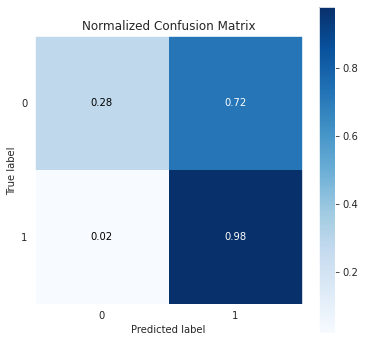

In [37]:
# realizando a classificação do conjunto de teste com nosso modelo otimizado
y_pred = rf_opt_over.predict(X_test)
y_prob = rf_opt_over.predict_proba(X_test)

precision, recall, threshold = precision_recall_curve(y_test, y_prob[:, 1])

print(classification_report(y_test, y_pred))
print(f'AUC: {round(auc(recall, precision), 2)}')
skplt.metrics.plot_confusion_matrix(y_test, y_pred, figsize=(6,6), normalize=True);

O classificador *Random Forest* com o SMOTE obteve a melhor performance entre todos com um *Recall* de 0.98. No entanto, vale destacar que o *Precision* ficou baixo com um valor de 0.33. Isso significa que identificaríamos 98% dos clientes que realizariam *churn*, porém, também classificaríamos equivocadamente 67% dos clientes que não cancelariam os serviços. Ou seja, o *trade-off* entre *Precision* e *Recall* não ficou bom. 

# Conclusão

Foi possível obter diversas informações sobre os clientes que deixam a empresa, além de termos comparado diferentes modelos para classificação desses clientes. Vimos que os classificadores com o melhor *trade-off* entre as métricas de *Precision* e *Recall* foram o XGBoost e o *Random Forest* aliados à técnica de *Undersampling* para balanceamento dos dados de treino.

No entanto, o classificador que conseguiu identificar a maior quantidade de pessoas que deixariam a empresa foi o *Random Forest* aliado à técnica de SMOTE. Para conseguir isso, ele perde muito no *Precision*, classificando erroneamente muitas pessoas que não deixariam a empresa.

Para saber qual das opções seria utilizada, dependeria muito do que é priorizado. Como é mais custoso para as empresas conseguirem novos clientes do que manter os atuais, talvez seja mais vantajoso utilizar o modelo que identifica a maior quantidade possível de *churn*. 

Esse seria um caso onde os diferentes cenários seriam levados aos *stakeholders* da empresa para tomada de decisão baseada em suas prioridades.

Muito obrigado por ficar até o final! Espero que você tenha aprendido como é possível utilizar modelos de *machine learning* para prever quais clientes deixarão a sua empresa. Se quiser descobrir mais aplicações dessa área, me siga também no [Github](https://github.com/beniciowg/data-science-projects) e no [LinkedIn](https://www.linkedin.com/in/benicio-wiggers-jr/).